Testing Trading Performance¶
This chapter shows how well our trained artificial brain would do if we were to use it for trading.

Previously we contructed a neural network and trained it until it can trade very close to optimal position over 1.5 years of minutely data. We will now test this brain using data it has not yet seen.

In [1]:
!python3 -m pip install --upgrade pip
!pip install kydb matplotlib feather-format s3fs boto3 --upgrade

  Using cached pip-20.2.4-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
  Using cached kydb-0.5.0-py3-none-any.whl (20 kB)
  Using cached matplotlib-3.3.3-cp36-cp36m-manylinux1_x86_64.whl (11.6 MB)
Processing /root/.cache/pip/wheels/9d/90/64/88411837e80bb520d15ae395f39359a5413e7a00ae63397e10/feather_format-0.4.1-py3-none-any.whl
  Using cached s3fs-0.5.1-py3-none-any.whl (21 kB)
     |████████████████████████████████| 129 kB 15.3 MB/s eta 0:00:01
  Using cached redis-3.5.3-py2.py3-none-any.whl (72 kB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyarrow-2.0.0-cp36-cp36m-manylinux2014_x86_64.whl (17.7 MB)
  Using cached aiobotocore-1.1.2-py3-none-any.whl (45 kB)
  Using cached fsspec-0.8.4-py3-none-any.whl (91 kB)
     |████████████████████████████████| 6.8 MB 

In [1]:
import sys
import os
sys.path.append(os.environ['HOME'] + '/epython-showcase')

## Imports

In [2]:
import feather
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
import math
from multiprocessing import Pool, cpu_count
import datetime
import kydb
import tsdb
from datetime import date
from ml.train_sequence import TrainSequence
%matplotlib inline

## Loading the data and trained model

In [3]:
db = kydb.connect('dynamodb://epython/timeseries')

In [4]:
ts = db['symbols/bitflyer/minutely/FX_BTC_JPY']

In [5]:
start_date = date(2019, 6, 1)
end_date = date(2019, 7, 1)
md = ts.curve(start_date, end_date)
md = md.sort_index()

PermissionError: Forbidden

In [ ]:
md

In [ ]:
## Create a sequence based on the market data loaded above. Be sure not to shuffle the data.
valid_data = md.reset_index().copy()
valid_data['position'] = 0
valid_seq = TrainSequence(valid_data, enable_shuffle=False, batch_size=60*24*2)

In [ ]:
model_file = 'fx_btc_jpy_model.h5'
db = kydb.connect('s3://epython')
model_data = db['/ml/models/' + model_file]
local_path = '/tmp/' + model_file
with open(local_path, 'wb') as f:
    f.write(model_data)
    
model = load_model(local_path)

In [ ]:
# Run the data through the model
ys_predict = model.predict(valid_seq, use_multiprocessing=True, workers=cpu_count())

In [ ]:
ys_predict[:,1]

In [ ]:
pnl_df.shape, pos.shape

In [ ]:
# Calculate position and PNL
#pnl_df = md[60*24:].copy()
pnl_df = md[-ys_predict.shape[0]:].copy()
pos = ys_predict[:, 1]
pnl_df['position'] = np.where(pos > 0.5, 1, -1)
pnl_df = pnl_df.join(pnl_df[['mid', 'position']].shift(), rsuffix='_prev')
pnl_df = pnl_df.iloc[1:].copy()
pnl_df['trade'] = pnl_df.position - pnl_df.position_prev
pnl_df.loc[pnl_df.index[0], 'trade'] = pnl_df.loc[pnl_df.index[0], 'position']
pnl_df['pnl'] = pnl_df.position_prev * (pnl_df.mid - pnl_df.mid_prev) - \
                pnl_df.trade * (pnl_df.ask - pnl_df.bid) / 2.
pnl_df['pnl'] = pnl_df.pnl.cumsum()

In [ ]:
def plot_trades(start_day, graph_num, ax1):    
    #plt.subplot(4,1,graph_num)
    #fig, ax1 = plt.subplots()#nrows=1, ncols=2, sharex=True)
    #fig, ax1 = plt.subplots()
    #ax1=plt.gca()
    start_date = start_day * 60 * 24
    end_date = start_date + 60 * 24 * 2
    df = pnl_df[start_date:end_date]
    ax1.plot(df[df.trade > 0.5].mid, 'go')
    ax1.plot(df[df.trade < -0.5].mid, 'ro')
    #df[df.trade > 0.5].mid.plot(ax=ax1, style='go')
    #df[df.trade > 0.5].mid.plot(ax=ax1, style='go')    
    #df[df.trade < -0.5].mid.plot(ax=ax1, style='ro')            
    ax1.get_xaxis().set_visible(False)
    ax2 = ax1.twinx()
    
    ax1.plot(df.mid, 'b-', linewidth=0.7)
    ax2.plot(df.pnl - df.loc[df.index[0], 'pnl'], 'c-') 
    ax2.get_xaxis().set_visible(False)


#plt.figure(figsize=(12,10))
start_days = (0, 5, 10, 16)
f, axs = plt.subplots(len(start_days), 1)
f.set_size_inches(18.5, 10.5)
#fig, ax1 = plt.subplots(4, 1)
for i, (ax, d) in enumerate(zip(axs, start_days)):
    plot_trades(d, i+1, ax)


## The final judgement

Now let's see how well the model do in the entire test period. Answer? Pretty well. Particularly interesting is the dangerous price jumps. The AI seemed to be able to capitalise on them.

 * Blue: Price
 * Green: PNL

NameError: name 'pnl_df' is not defined

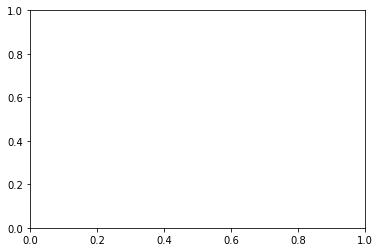

In [7]:
fig, ax1 = plt.subplots()
pnl_df.pnl.plot(ax=ax1, style='g', label='pnl')
ax1.legend(bbox_to_anchor=(0, 0), ncol=2)
ax2 = ax1.twinx()
pnl_df.mid.plot(ax=ax2, style='b', label='price')
ax2.legend(bbox_to_anchor=(1.2, 0), ncol=2)